In [4]:
import propagators
import energy_landscapes
import energy_landscapes_gaussian
import long_simulation
import weighted_ensemble_3
import numpy as np
import MSM_methods
import analysis
import msm_analysis
import metadynamics
from collections import Counter

import matplotlib.pyplot as plt
import importlib

#methods for fast print debugging
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)


In [34]:
#shared parameters

kT = 1
dt = 0.001
n_analysis_bins = 50
save_period = 100 #in steps
aggregate_simulation_limit = 100000
molecular_time_limit = 1000
n_bootstrap = 3

#energy_landscapes.unit_double_well()
# system1.plot_quantity(system1.potential)
# plt.show()

system1 = energy_landscapes_gaussian.two_wells_decoy_valley()

#TODO: we need to add a way to model methods that serially use a single core to mimic parallel computations (i.e. if you tried to run WESTPA on one GPU core)
#this is relevant for cases where the total number of GPUs is the limiting factor (see below)

#hardware/real world objects:
# GPUs, wall clock hours, aggregate GPU hours
#if we're trying to model a commercial cluster where we can buy as many gpus as we want at any one time but have to pay per GPU hour, wall clock time and aggregate GPU hours are the relevant metrics
#if we're trying to model a lab cluster where we have a fixed number of GPUs and a fixed amount of time to publish and graduate, wall clock time and the number of GPUs are the relevant metrics

#simulation parameters (both are maximum values):
# aggregate simulation time, maximum molecular time
# AKA (how much the simulation costs, how much time it adds to your PhD)



In [35]:
def run_for_n_timepoints(analysis_method, params, initial_state, n_timepoints):

    method_state = initial_state
    method_output = []

    for t in range(n_timepoints):
        method_state, observable = analysis_method(method_state, params)
        method_output.append(observable)

    return method_output


def parallel_trj_histogram(state, params):
    long_trjs, long_trj_inds = state
    system, kT, dt, nsteps, save_period, binbounds = params

    long_trjs, long_trj_inds = long_simulation.resume_parallel_simulations_msm(propagators.propagate_msm, system, kT, dt, nsteps, save_period, long_trjs, long_trj_inds)

    #actual state populations
    state_bins = msm_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
    unique_state_bins = np.unique(state_bins)
    sb_dict = {}
    for sb in unique_state_bins:
        sb_dict[sb] = 0
    for sb, p in zip(state_bins, system.p):
        sb_dict[sb] += p

    state_pops = sb_dict.values()

    #estimated state populations
    binned_trj = msm_analysis.bin_to_voxels_msmtrj(binbounds, system1.x, long_trj_inds)
    state_counts = Counter(binned_trj.flatten())
    total_counts = len(binned_trj.flatten())
    est_state_pops = [state_counts[sb]/total_counts for sb in unique_state_bins]

    maew = np.mean([spi*abs(espi-spi) for spi, espi in zip(state_pops, est_state_pops)])
    
    plt.plot(state_pops)
    plt.plot(est_state_pops)

    return (long_trjs, long_trj_inds), maew


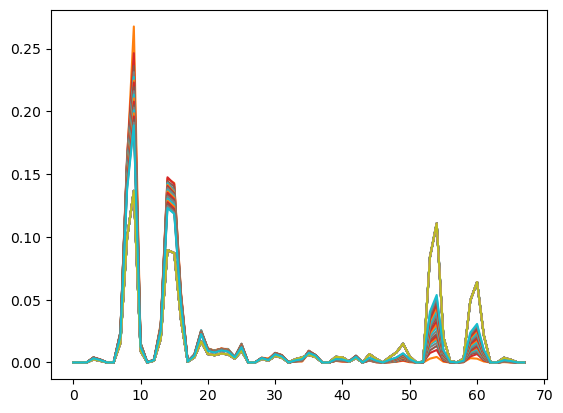

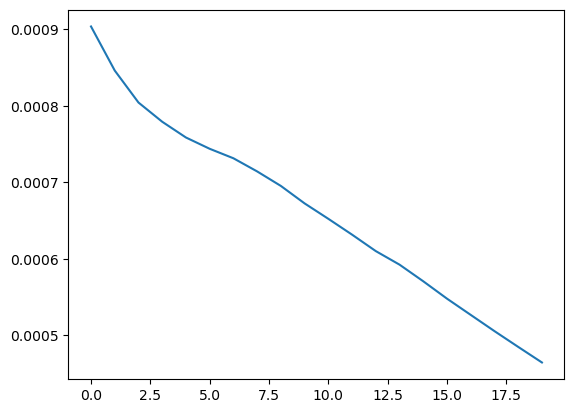

In [36]:
importlib.reload(msm_analysis)
importlib.reload(long_simulation)

n_timepoints = 20
nbins = 40

n_parallel = int(round(aggregate_simulation_limit/molecular_time_limit))
nsteps = int(round(aggregate_simulation_limit/(n_parallel*n_timepoints)))


binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
             np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]
#print(binbounds)

long_trjs = np.array([system1.standard_init_coord for element in range(n_parallel)]).reshape((n_parallel, 1, len(system1.standard_init_coord)))
long_trj_inds = np.array([system1.standard_init_index for element in range(n_parallel)]).reshape((n_parallel, 1))

initial_state = (long_trjs, long_trj_inds)
params = (system1, kT, dt, nsteps, save_period, binbounds)
maew_convergence = run_for_n_timepoints(parallel_trj_histogram, params, initial_state, n_timepoints)
plt.show()

plt.plot(maew_convergence)
# long_trjs, long_trj_inds = long_simulation.resume_parallel_simulations_msm(propagators.propagate_msm, system1, kT, dt, nsteps, save_period, long_trjs, long_trj_inds)

# binned_trj = msm_analysis.bin_to_voxels_msmtrj(binbounds, system1.x, long_trj_inds)
# plt.hist(binned_trj.flatten(), density = True, range = (0,120), bins = nbins)

# state_bins = msm_analysis.bin_to_voxels_msmstates(binbounds, system1.x)

# plt.hist([state_bins], weights=system1.p, color="red", density = True, range = (0,120), alpha = 0.5, bins = nbins)

In [25]:
system1.x

array([[ 8.40900656e+00,  1.81253124e+00],
       [ 8.39318626e-01, -2.30591527e+00],
       [ 6.16703313e+00,  1.91247145e+00],
       [ 6.66893295e+00,  2.08460644e+00],
       [ 9.34182159e-01,  1.98013622e+00],
       [ 1.94698477e+00, -1.41046981e+00],
       [ 6.90328576e+00, -1.14503888e+00],
       [ 5.36368639e+00, -2.49386214e+00],
       [ 2.07848264e+00, -2.33903004e+00],
       [-1.04979481e+00,  1.86791865e+00],
       [ 3.42082307e+00, -2.76710014e+00],
       [ 9.20335116e+00, -3.09597579e-01],
       [ 6.30075820e+00,  2.98003420e+00],
       [ 2.26653008e+00, -1.77197998e+00],
       [ 7.52645736e+00,  9.56624340e-02],
       [ 6.55124015e+00, -1.13898661e+00],
       [ 4.82306662e+00, -1.80621563e+00],
       [-1.32122459e+00, -4.04643954e-01],
       [ 6.60038050e+00,  1.64278434e+00],
       [ 7.81116119e+00, -1.56320849e+00],
       [ 2.85344761e+00,  2.23749334e+00],
       [-1.22223060e+00, -9.02551825e-01],
       [ 8.52500804e+00,  5.31659786e-01],
       [ 1.

In [ ]:
importlib.reload(analysis)
importlib.reload(long_simulation)
importlib.reload(weighted_ensemble_3)
importlib.reload(propagators)
importlib.reload(energy_landscapes_gaussian)
importlib.reload(energy_landscapes)
importlib.reload(MSM_methods)
importlib.reload(metadynamics)



# #system1 = energy_landscapes_gaussian.two_wells_decoy_valley()

# #long_simulation.long_simulation_histogram_analysis, long_simulation.long_simulation_hamsm_analysis, weighted_ensemble_2.weighted_ensemble_hamsm_analysis
# mfpts_all, populations_all, agg_t_maew_all = analysis.bootstrap_method_comparison(
#     3, 
#     [long_simulation.long_simulation_histogram_analysis],
#     #  long_simulation.long_simulation_histogram_analysis_mtd, 
#     #  long_simulation.long_simulation_msm_analysis, 
#     #  weighted_ensemble_3.weighted_ensemble_msm_analysis], 
#     system1, kT, dt, 
#     aggregate_simulation_limit, molecular_time_limit, save_period, 
#     n_analysis_bins, n_timepoints=5)

# analysis.plot_bootstrapping_results(populations_all, system1, kT, n_analysis_bins)
# plt.show()
# analysis.plot_convergence(agg_t_maew_all)
# plt.show()

#TODO implement MFPT comparison
#TODO fast synthetic trajectories
#TODO compare MSMs built with and without weights

In [ ]:
a = [(0,1),(2,3)]
print(a)

b = (0,1)
print(b in a)

In [ ]:
b = [0,1]
print(b)
print(tuple(b))